In [3]:

import numpy as np
import subprocess
import os
import sys
import shutil, fnmatch
from linecache import getline, clearcache
from jupyprint import jupyprint  
from IPython.display import display, FileLink, FileLinks, HTML
import matplotlib.pyplot as plt
from clawpack.visclaw import animation_tools
import numpy as np
plt.rcParams['text.usetex'] = True
from scipy.special import lambertw
from scipy.integrate import odeint
from scipy import interpolate

def export_setrun(xlim,xmax,mx,tmax,nbsim,a,mu,method):
    setrun = open('AddSetRun.py','w')
    setrun.write("# Modified by reading_output.ipynb\n")
    setrun.write("xlim = "+str(xlim)+'\n')
    setrun.write("xmax = "+str(xmax)+'\n')
    setrun.write("mx = "+str(mx)+'\n')
    setrun.write("tmax = "+str(tmax)+'\n')
    setrun.write("nbsim = "+str(nbsim)+'\n')
    setrun.write("a = "+str(a)+'\n')
    setrun.write("mu = "+str(mu)+'\n')
    setrun.write("method = "+str(method)+'\n')
    setrun.close()

def check_claw():
    CLAW = os.environ['CLAW']
    if CLAW=='':
        claw = False
        with open(home+'/.bashrc') as f:
            datafile = f.readlines()
        for line in datafile:
            s="CLAW"
            if s in line and line.find('#')==-1:
                claw=(str.split(line))[1]
                claw = home+claw.replace("CLAW=$HOME", "")
                return claw
            
        if not claw:
            print("Error: I cannot determine the $CLAW variable...")
            print("Please modify the script and define it explicitely")
            return claw
    else:
        return CLAW
 

# Running clawpack

In [101]:
xlim = 1
xmax = 2
mx   = 1000
tmax = 5
nbsim = 50
a  = 1
mu = 20
method = 2
export_setrun(xlim,xmax,mx,tmax,nbsim,a,mu,method)

In [102]:
# Répertoire
CLAW = check_claw()
répertoire_travail = os.getcwd() 
répertoire_résultat = os.path.join(répertoire_travail, '_output')
 
print('* Claw address: ',CLAW)
print('* Main directory: ',répertoire_travail)

subprocess.run(["make","clean" ])

subprocess.run(["make",".output"],
               # comment if desired
               capture_output = True, text = True)

* Claw address:  /home/ancey/clawpack_git/clawpack
* Main directory:  /home/ancey/7_Burgers_classic_nonlinear_src
rm -f xclaw                          qinit.f.html setprob.f.html  exchange.f90.html fsolve.f90.html qinit.f90.html src1.f90.html  AddSetRun.py.html setplot.py.html setrun.py.html claw.data.html setprob.data.html   Makefile.html
rm -f .data .output .plots .htmls 


CompletedProcess(args=['make', '.output'], returncode=0, stdout='# after checking dependencies above are up-to-date, link the objects...\n\nDONE COMPILING, NOW LINKING....\ngfortran     exchange.o     qinit.o setprob.o src1.o fsolve.o /home/ancey/clawpack_git/clawpack/riemann/src/rp1_burgers.o /home/ancey/clawpack_git/clawpack/classic/src/1d/setaux.o /home/ancey/clawpack_git/clawpack/classic/src/1d/bc1.o /home/ancey/clawpack_git/clawpack/classic/src/1d/b4step1.o /home/ancey/clawpack_git/clawpack/classic/src/1d/driver.o /home/ancey/clawpack_git/clawpack/classic/src/1d/claw1ez.o /home/ancey/clawpack_git/clawpack/classic/src/1d/claw1.o /home/ancey/clawpack_git/clawpack/classic/src/1d/copyq1.o /home/ancey/clawpack_git/clawpack/classic/src/1d/inlinelimiter.o /home/ancey/clawpack_git/clawpack/classic/src/1d/opendatafile.o /home/ancey/clawpack_git/clawpack/classic/src/1d/out1.o /home/ancey/clawpack_git/clawpack/classic/src/1d/step1.o  -I./ -L/home/ancey/7_Burgers_classic_nonlinear_src/  -o xc

# Reading output

In [103]:
from os.path import expanduser
home = expanduser("~")

#répertoire_travail  = os.path.join(HOME, 'run_lac_6/')
répertoire_travail  = os.getcwd()
répertoire_résultat = os.path.join(répertoire_travail, '_output')
sys.path.insert(0,répertoire_travail)  

print('Directory where the data are: \n  %s' % répertoire_résultat)
if not os.path.isdir(répertoire_travail):
      print('*** Check directory (I cannot find it)')

fichiers = fnmatch.filter(os.listdir(répertoire_résultat), 'fort.q*' )
fichiers.sort()
NbSim    = len(fichiers)
print(f"There are {NbSim}  fort.q* files.")

Directory where the data are: 
  /home/ancey/7_Burgers_classic_nonlinear_src/_output
There are 51  fort.q* files.


In [104]:

clearcache()
source = répertoire_résultat+'/'+fichiers[0]
header = [getline(source, i) for i in range(1, 6)]
values = [float(h.split()[0].strip()) for h in header]
keys = [ (h.split()[-1].strip()) for h in header]
dictionnaire = {keys[k]:values[k] for k in range(0,5)}
xlow = dictionnaire['xlow']
mx = int(dictionnaire['mx'])
dx = dictionnaire['dx']
nbsim = len(fichiers)
xupper = xlow+mx*dx

fichiers_t = fnmatch.filter(os.listdir(répertoire_résultat), 'fort.t*' )
fichiers_t.sort()
tmax = float((getline(répertoire_résultat+'/'+fichiers_t[-1],1).split())[0])
dt = tmax/(NbSim-1)
jupyprint(" $x_{min}$ ="+f" {xlow}")
jupyprint(" $x_{max}$ ="+f" {xupper}")
jupyprint(" $\\mathrm{d}x $ ="+f" {dx}")
jupyprint(f"mx = {mx}")
jupyprint(" $t_{max}$ ="+f" {tmax:.2f}")
jupyprint(" $\\mathrm{d}t $ ="+f" {dt:.2f}")

source = répertoire_travail+'/setprob.data'
header = [getline(source, i) for i in range(7, 11)]
values = [float(h.split()[0].strip()) for h in header]
keys = [ (h.split()[-1].strip()) for h in header]
dictionnaire = {keys[k]:values[k] for k in range(0,4)}
mu = dictionnaire['mu']
xlim = int(dictionnaire['xlim'])
a = dictionnaire['a']
jupyprint(" $\\mu $ ="+f" {mu}")
jupyprint(" $x_{lim} $ ="+f" {xlim}")
jupyprint(" $a $ ="+f" {a}")
print(f" method: {method}")

 $x_{min}$ = 0.0

 $x_{max}$ = 2.0

 $\mathrm{d}x $ = 0.002

mx = 1000

 $t_{max}$ = 5.00

 $\mathrm{d}t $ = 0.10

 $\mu $ = 20.0

 $x_{lim} $ = 1

 $a $ = 1.0

 method: 2


In [105]:
frames = np.zeros((NbSim,mx))
for i in range(0,NbSim):
    f = fichiers[i]
    data = np.loadtxt(répertoire_résultat+'/'+f,skiprows=6)
    frames[i] = data

In [106]:
x = np.linspace(xlow,xupper,mx)
figs = []
hauteurs = []
hmax = frames.max()
L  = (xupper+xlow)/2
temps_in = np.linspace(0,tmax,NbSim)


def c(x,t,a,mu):
	if t>0:
		cc = x+1/a/t
		if cc<700:
			value = np.real(-1/a/t/mu+lambertw(1/a/t*np.exp(mu*x+1/a/t),  k=0, tol=1e-8)/mu)
		else:
			value = x/(1+a*t)
	else:
		value = x
	return value

def u(x,t,a,mu):
	return a*c(x,t,a,mu)/(a*c(x,t,a,mu)*t*mu+1)

def edo(x,t,a,mu):
	dxdt = u(x,t,a,mu)/2
	return dxdt

t = np.linspace(0,tmax,500)
x0 = xlim
xf_data = np.ravel(odeint(edo, x0, t, args=(a,mu)))
x_f = interpolate.interp1d(t,xf_data)

def sol(x,t,a,xlim,mu):
    s = 0
    
    if (x<=x_f(t)):
            if mu > 0:
                s = u(x,t,a,mu)  #a*x*np.exp(-mu*t)/(1+a*(1-np.exp(-mu*t)))
            else:
                 s = a*x/(1+a*t)
    return s


def ExportAnimation():
    
   
    for i in range(0,NbSim):
        
        h_i = frames[i]

        hauteurs.append(h_i)
        fig  = plt.figure( figsize=(10,2))
        axes = plt.subplot(1, 1, 1)

        axes.set_xlabel(r'$x $',fontsize=14)
        axes.set_ylabel(r'$z $',fontsize=14)
        axes.set_ylim((0,hmax))


        axes.set_xlabel(r'$x $',fontsize=14)
        axes.set_ylabel(r'$u(x,t) $',fontsize=14)
            

        text = axes.text(L/2,  0.8*hmax, '')
        tt = temps_in[i]
        sol_i = [sol(xi,tt,a,xlim,mu) for xi in x]
        val = f'{tt:.1f}'
        text.set_text(r'$ t = {} $ s '.format(val))
            
            

        axes.set_title(" ")


        axes.plot(x , h_i, color = 'deepskyblue',label='numerical solution')
        axes.plot(x , sol_i, color = 'red', linestyle = '--',label='theoretical solution')
        axes.legend(frameon=False)
        #axes.plot(distance, eta_i, 'b')
        figs.append(fig)
        plt.close(fig)

    return figs

In [107]:
figures = ExportAnimation()
animation_tools.interact_animate_figs(figures, manual=True)

interactive(children=(IntSlider(value=0, description='frameno', max=50), Button(description='Run Interact', st…

In [108]:
# Animation
images = animation_tools.make_images(figures)
anim = animation_tools.animate_images(images, figsize=(12,4))
HTML(anim.to_jshtml())

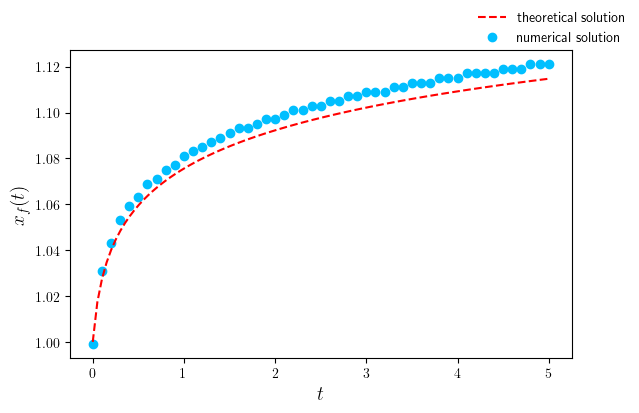

In [109]:
time = np.linspace(0,tmax,100)
xfront = [x_f(t) for t in time]
xf_claw = [x[frames[i]>1.0e-6][-1] for i in range(0,nbsim)]

golden = (1 + 5 ** 0.5) / 2
fig  = plt.figure( figsize=(4*golden,4))
axes = plt.subplot(1, 1, 1)
axes.plot(time,xfront,linestyle='--',color='red',label='theoretical solution')
axes.scatter(temps_in,xf_claw,color = 'deepskyblue',label='numerical solution')
axes.set_xlabel(r'$t $',fontsize=14)
axes.set_ylabel(r'$x_f(t) $',fontsize=14)
fig.legend(frameon=False)

In [51]:
fig.savefig('xf_nl-burgers-src_mu='+str(mu)+'_method='+str(method)+'.png',dpi=300,bbox_inches='tight')

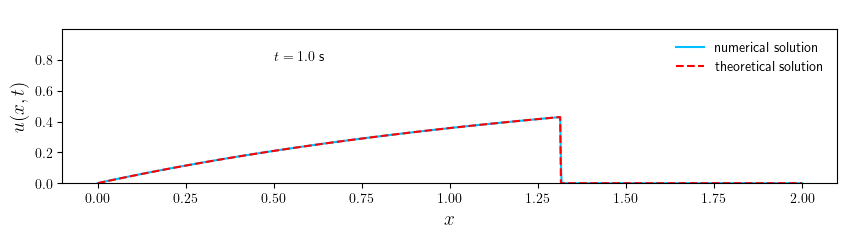

In [48]:
figures[10]

In [49]:
figures[10].savefig('burgers-nonlinear-src_mu='+str(mu)+'_method='+str(method)+'.png',dpi=300,bbox_inches='tight')